________
# I: Librairies 

### pip install

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 37.5 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Librairies 

In [ ]:
# to deal with maths
import pandas as pd
import numpy as np
import random
import torch
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# to deal with graphs
from keras.utils import load_img
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from collections import defaultdict # we use it to create color map
import visualkeras

# to deal with folders
import os
import glob as gb
import shutil # automating process of copying and removal of files and directories
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# DL
import tensorflow as tf
import cv2
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras import Input
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Activation
import string
import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Check versions
!python --version
print('TensorFlow ', tf.__version__)
print('Keras ', tf.keras.__version__)

Python 3.10.11
TensorFlow  2.12.0
Keras  2.12.0


### Random Seed

In [ ]:
# fix random seed for reproducibility
np.random.seed(5)

# random_state
RANDOM_STATE = 44

# # to avoid GPU errors
# physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

________
# II: Data Preparation

### 1: Download the dataset from kaggle

In [ ]:
# One time for runtime
# Download and use kaggle data within Google Colab:
# 1. Click on kaggel profile icon
# 2. Click Account
# 3. Scroll to the API section
# 4. Click Expire API Token
# 5. Then click Create New API Token
# 6. You will then have new API credentials in the file kaggle.json
# 7. install kaggle in colab
! pip install -q kaggle

# 8: Choose the "kaggle.json" file that you downloaded
from google.colab import files
files.upload()
# 9: Make directory named kaggle
! mkdir ~/.kaggle

# 10: copy kaggle.json file there
! cp kaggle.json ~/.kaggle/

# 11: Change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json

# 12: Now you can check if everything's okay by running this command
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                                title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                              Data Science Salaries 2023 💸                       25KB  2023-04-13 09:55:16           9387        249  1.0              
asahu40/walmart-data-analysis-and-forcasting                       Walmart Data Analysis and Forcasting              122KB  2023-04-26 07:07:03           1171         31  1.0              
ahmedshahriarsakib/usa-real-estate-dataset                         USA Real Estate Dataset                             1MB  2023-04-30 03:51:36            889         27  1.0              
iammustafatz/diabetes

In [ ]:
# 13: to download a dataset that are NOT part of a competition (regular dataset)
! kaggle datasets download -d grassknoted/asl-alphabet -p /content/sample_data/dataset/ --unzip

100% 1.03G/1.03G [00:27<00:00, 42.8MB/s]
100% 1.03G/1.03G [00:27<00:00, 39.4MB/s]


### 2: Checking Dimention and Images size (check the data before choosing img_size)

##### 1: Training dataset

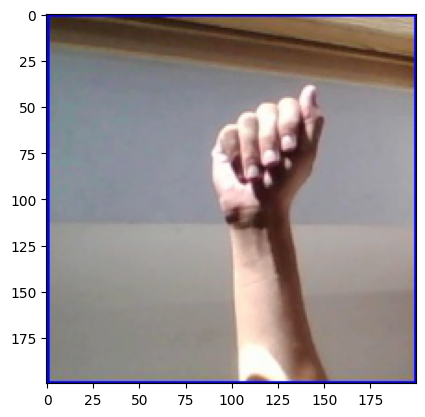

In [ ]:
# We can check the training data by looking at one image of each of the alphabets to make sure that none of them are missing from our data.
train_alphabet_filenames = os.listdir("/content/sample_data/dataset/asl_alphabet_train/asl_alphabet_train/A/")
sample = random.choice(train_alphabet_filenames)
image = load_img("/content/sample_data/dataset/asl_alphabet_train/asl_alphabet_train/A/"+sample)
plt.imshow(image)

# delete useless variables
del train_alphabet_filenames, sample, image

<ipython-input-17-9fde26baaffb>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 20))


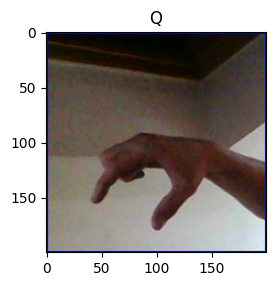

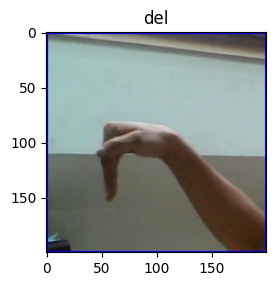

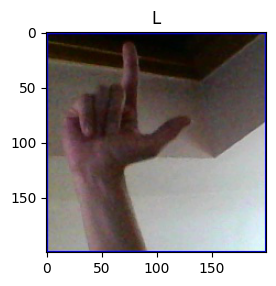

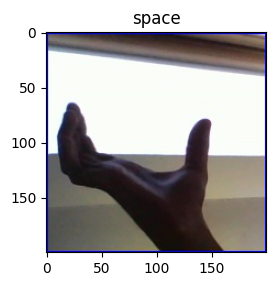

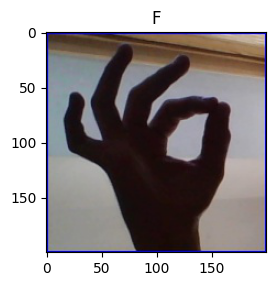

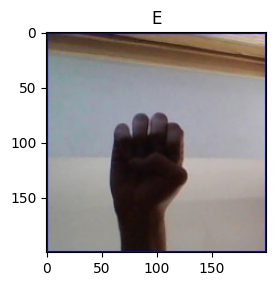

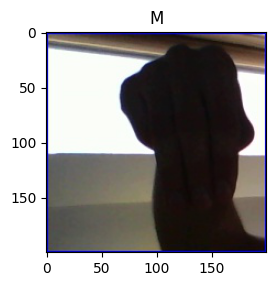

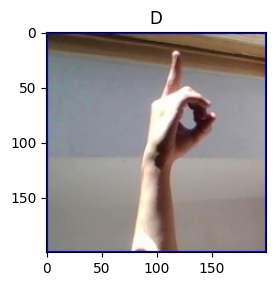

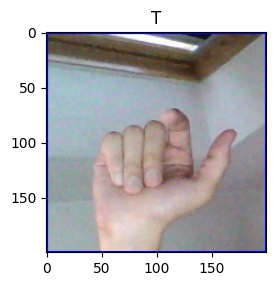

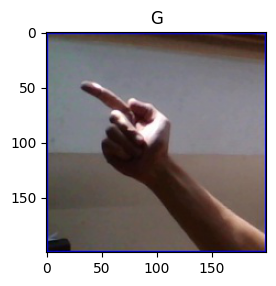

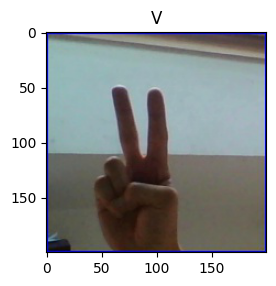

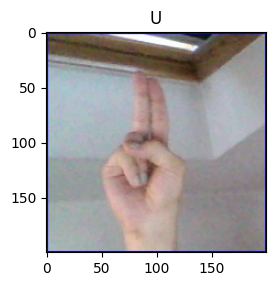

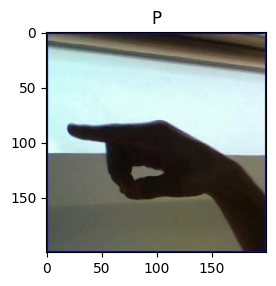

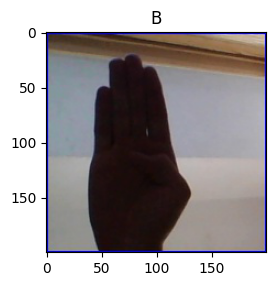

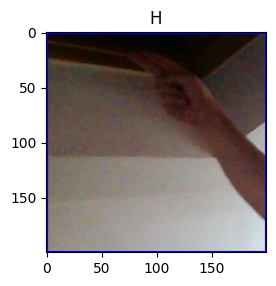

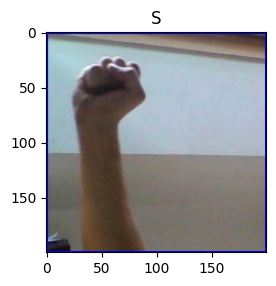

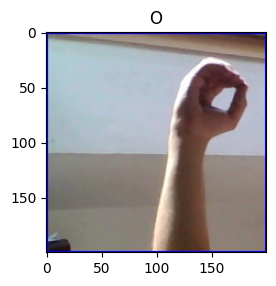

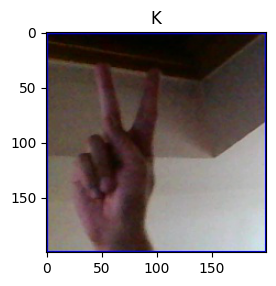

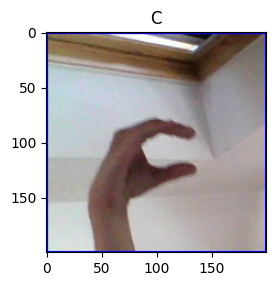

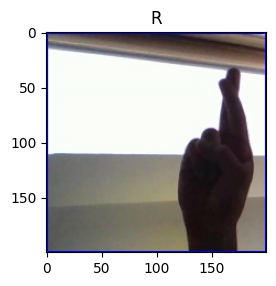

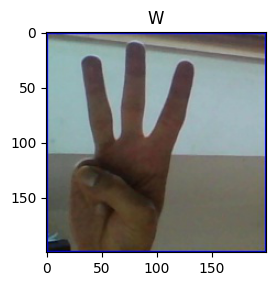

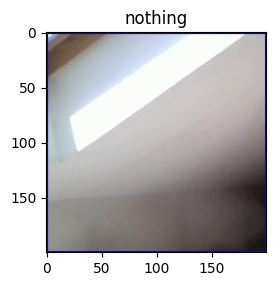

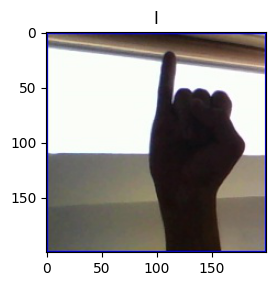

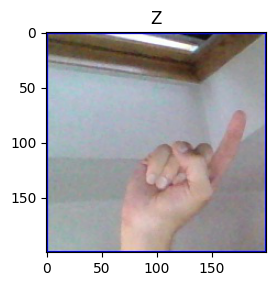

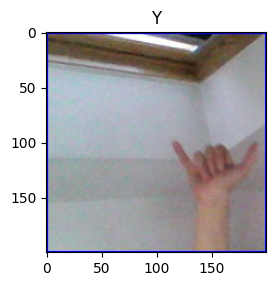

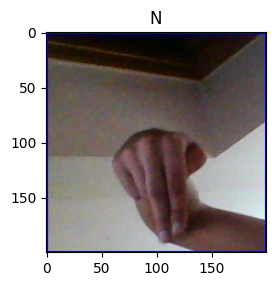

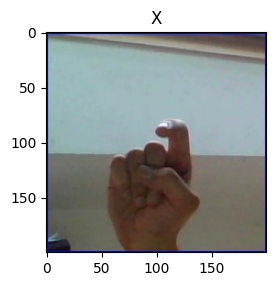

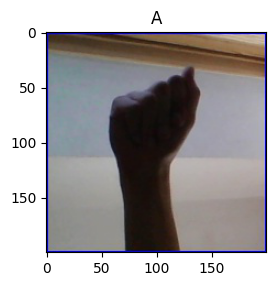

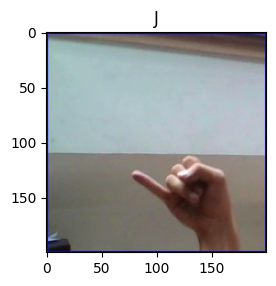

In [ ]:
# We can check the training data by looking at one image of each of the alphabets to make sure that none of them are missing from our data.
TRAIN_PATH = '/content/sample_data/dataset/asl_alphabet_train/asl_alphabet_train/'

folders = os.listdir(TRAIN_PATH) 
for folder in folders:
  plt.figure(figsize=(20, 20))
  plt.subplot(6, 5, 30)
  files = os.listdir(TRAIN_PATH + folder)
  sample = random.choice(files)
  image = load_img(TRAIN_PATH + folder + '/' + sample)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.title(folder)



In [ ]:
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

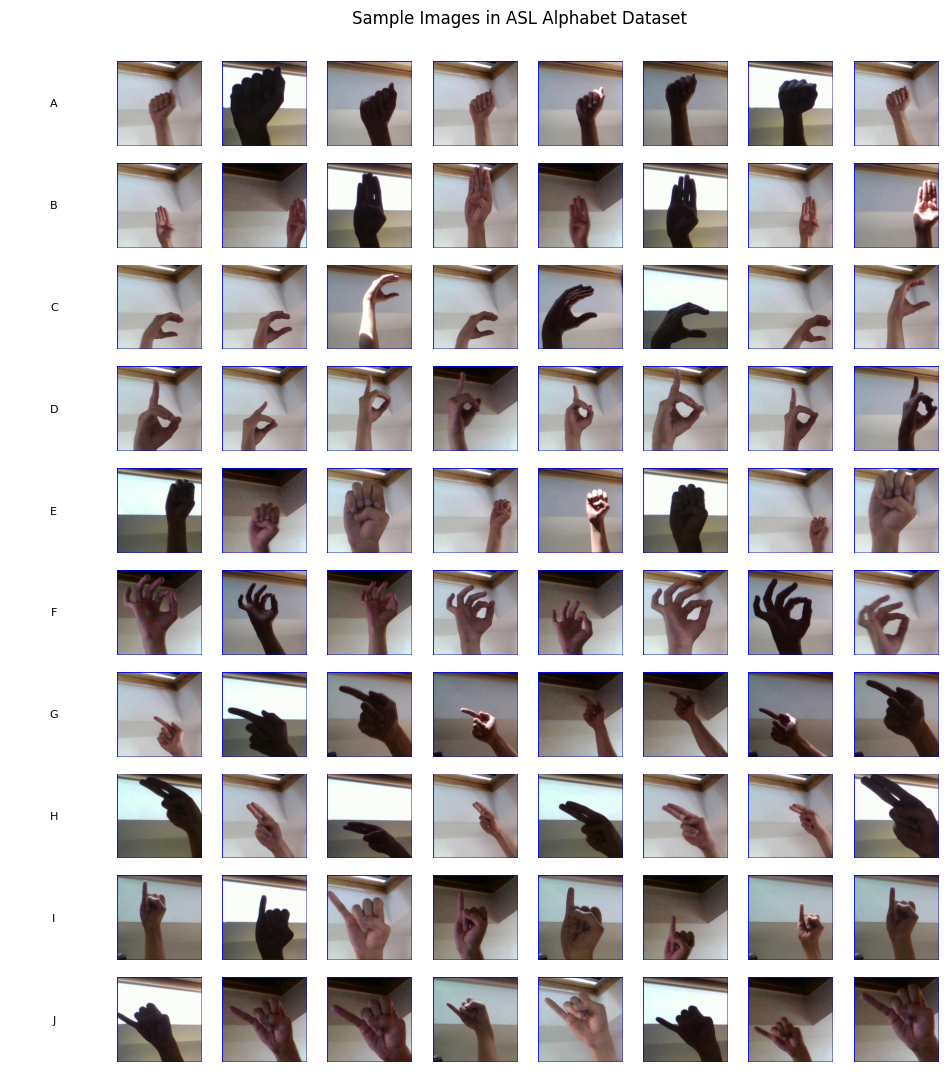

In [ ]:
sample_images(labels[:10])

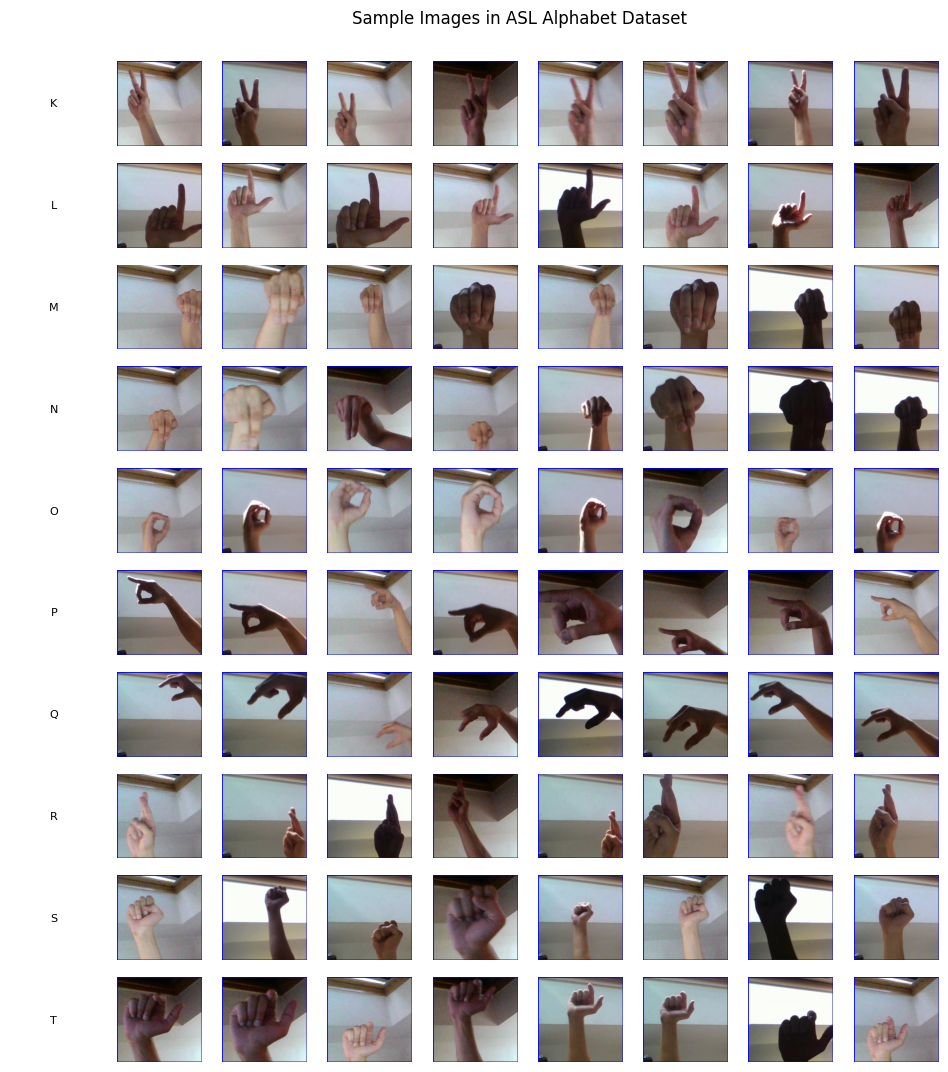

In [ ]:
sample_images(labels[10:20])

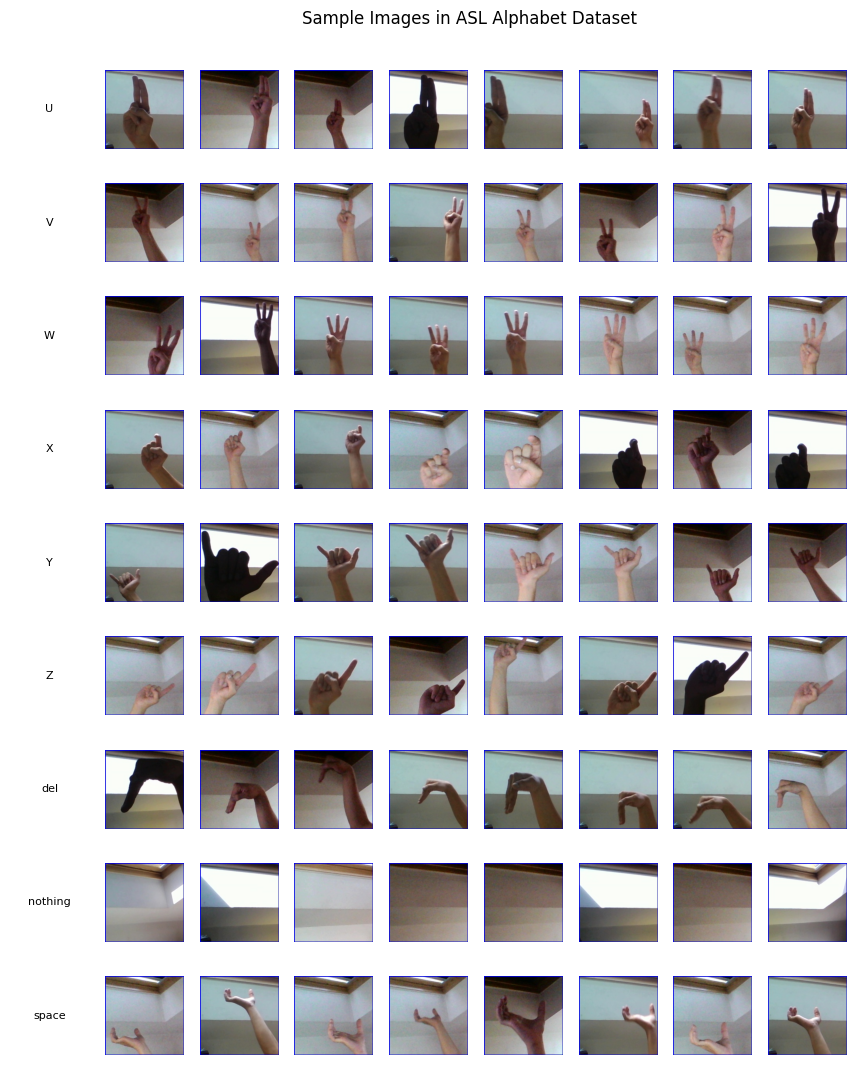

In [ ]:
sample_images(labels[20:])

In [ ]:
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)
    
    sign_label = [label] * len(image_files)
    
    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

image_path  label
0      /content/sample_data/dataset/asl_alphabet_trai...      A
1      /content/sample_data/dataset/asl_alphabet_trai...      A
2      /content/sample_data/dataset/asl_alphabet_trai...      A
3      /content/sample_data/dataset/asl_alphabet_trai...      A
4      /content/sample_data/dataset/asl_alphabet_trai...      A
...                                                  ...    ...
86995  /content/sample_data/dataset/asl_alphabet_trai...  space
86996  /content/sample_data/dataset/asl_alphabet_trai...  space
86997  /content/sample_data/dataset/asl_alphabet_trai...  space
86998  /content/sample_data/dataset/asl_alphabet_trai...  space
86999  /content/sample_data/dataset/asl_alphabet_trai...  space

[87000 rows x 2 columns]

In [ ]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"], 
    test_size=0.15, 
    random_state=2023, 
    shuffle=True, 
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

image_path    label
51901  /content/sample_data/dataset/asl_alphabet_trai...        R
51887  /content/sample_data/dataset/asl_alphabet_trai...        R
5050   /content/sample_data/dataset/asl_alphabet_trai...        B
29446  /content/sample_data/dataset/asl_alphabet_trai...        J
58405  /content/sample_data/dataset/asl_alphabet_trai...        T
...                                                  ...      ...
47111  /content/sample_data/dataset/asl_alphabet_trai...        P
83611  /content/sample_data/dataset/asl_alphabet_trai...  nothing
67329  /content/sample_data/dataset/asl_alphabet_trai...        W
85296  /content/sample_data/dataset/asl_alphabet_trai...    space
60158  /content/sample_data/dataset/asl_alphabet_trai...        U

[58103 rows x 2 columns]

image_path label
24961  /content/sample_data/dataset/asl_alphabet_trai...     I
71053  /content/sample_data/dataset/asl_alphabet_trai...     X
73637  /content/sample_data/dataset/asl_alphabet_trai...     Y
72875  /content/sample_data/dataset/asl_alphabet_trai...     Y
40669  /content/sample_data/dataset/asl_alphabet_trai...     N
...                                                  ...   ...
16474  /content/sample_data/dataset/asl_alphabet_trai...     F
62741  /content/sample_data/dataset/asl_alphabet_trai...     U
32281  /content/sample_data/dataset/asl_alphabet_trai...     K
20451  /content/sample_data/dataset/asl_alphabet_trai...     G
2962   /content/sample_data/dataset/asl_alphabet_trai...     A

[15847 rows x 2 columns]

image_path  label
73327  /content/sample_data/dataset/asl_alphabet_trai...      Y
85482  /content/sample_data/dataset/asl_alphabet_trai...  space
65607  /content/sample_data/dataset/asl_alphabet_trai...      V
53903  /content/sample_data/dataset/asl_alphabet_trai...      R
64425  /content/sample_data/dataset/asl_alphabet_trai...      V
...                                                  ...    ...
40578  /content/sample_data/dataset/asl_alphabet_trai...      N
28949  /content/sample_data/dataset/asl_alphabet_trai...      J
42094  /content/sample_data/dataset/asl_alphabet_trai...      O
5425   /content/sample_data/dataset/asl_alphabet_trai...      B
49381  /content/sample_data/dataset/asl_alphabet_trai...      Q

[13050 rows x 2 columns]

In [ ]:
# Data Augmentation (Just Rescale)
def data_augmentation():
    datagen = ImageDataGenerator(rescale=1/255.,)
    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=CFG.batch_size,
        target_size=(CFG.img_height, CFG.img_width),
    )
    
    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(CFG.img_height, CFG.img_width),
        shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

In [ ]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 10
    num_classes = 29
    img_channels = 3
    
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
seed_everything(2023)
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0  

None

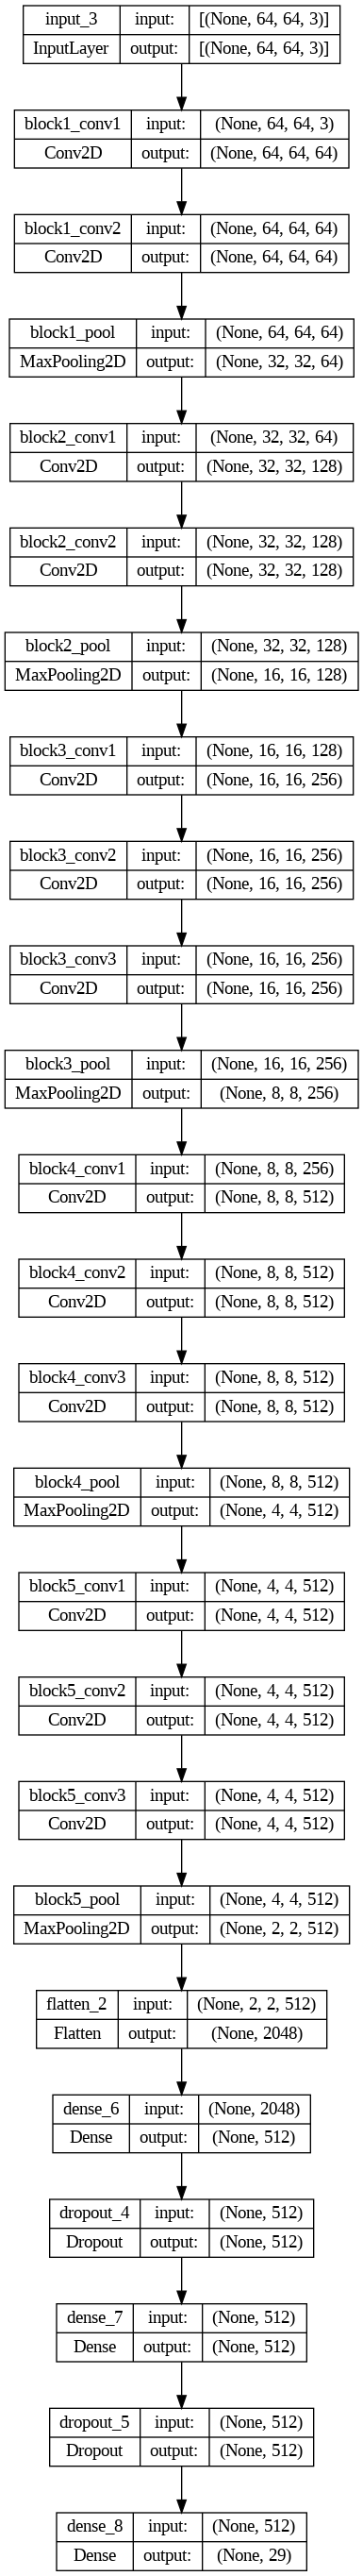

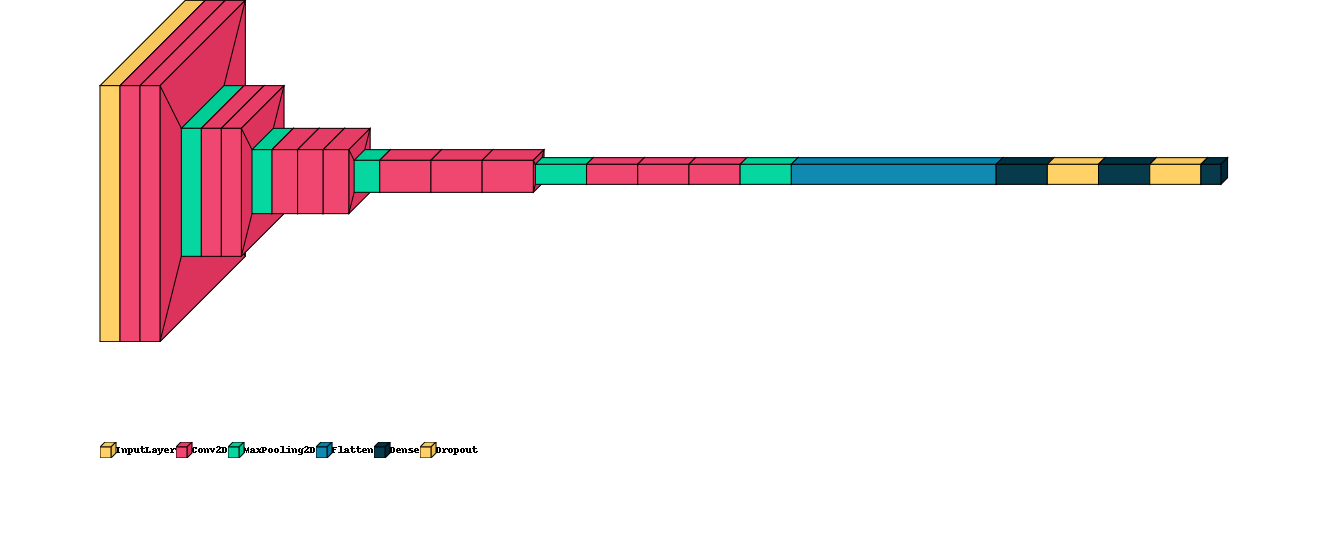

In [ ]:
# Load VGG16 model 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

display(model.summary())
display(tf.keras.utils.plot_model(model, to_file='archi.png', show_shapes=True))

visualkeras.layered_view(model, 
                         to_file='archi-model.png', 
                         color_map=None, # color map or none
                         type_ignore=[], # ignoring layers by their type
                         index_ignore=[], # ignoring layers by their index
                         background_fill='white', # background color
                         draw_volume=True, # Flat Style or not
                         padding=100, # padding between left to center of image
                         spacing=0, # global distance between two layers
                         legend=True, # legend or not
                         #font=text_font, # font type
                         font_color='black' # font color
                         )

In [ ]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('asl_vgg16_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
# Train the Model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CFG.batch_size,
    epochs=CFG.epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // CFG.batch_size,
    callbacks=[checkpoint]
)

Epoch 1/10
907/907 [==============================] - 155s 159ms/step - loss: 1.1019 - accuracy: 0.6535 - val_loss: 0.2575 - val_accuracy: 0.9307
Epoch 2/10
907/907 [==============================] - 124s 137ms/step - loss: 0.4050 - accuracy: 0.8627 - val_loss: 0.1250 - val_accuracy: 0.9624
Epoch 3/10
907/907 [==============================] - 113s 125ms/step - loss: 0.2830 - accuracy: 0.9040 - val_loss: 0.0847 - val_accuracy: 0.9753
Epoch 4/10
907/907 [==============================] - 126s 139ms/step - loss: 0.2494 - accuracy: 0.9146 - val_loss: 0.0717 - val_accuracy: 0.9791
Epoch 5/10
907/907 [==============================] - 124s 136ms/step - loss: 0.2200 - accuracy: 0.9249 - val_loss: 0.0690 - val_accuracy: 0.9787
Epoch 6/10
907/907 [==============================] - 124s 137ms/step - loss: 0.1937 - accuracy: 0.9345 - val_loss: 0.0478 - val_accuracy: 0.9865
Epoch 7/10
907/907 [==============================] - 104s 114ms/step - loss: 0.1785 - accuracy: 0.9402 - val_loss: 0.0523 -

In [ ]:
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy", scores[1]*100))

13050/13050 [==============================] - 87s 7ms/step - loss: 0.0359 - accuracy: 0.9916
Evaluate Test Accuracy: 99.16%


In [ ]:
# Visualize Training and Validation Results

# Create Subplot
fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Model Loss", "Model Accuracy"], 
)

# Configuration Plot
class PlotCFG:
    marker_size = 8
    line_size = 2
    train_color = "#76503d"
    valid_color = "#deb392"

# Loss Plot
loss = history.history['loss']
val_loss = history.history['val_loss']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(loss)+1), y=loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Loss"
    ), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_loss)+1), y=val_loss,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Loss"
    ), row=1, col=1
)

# Accuracy Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(acc)+1), y=acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.train_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.train_color, width=PlotCFG.line_size),
        name="Training Accuracy"
    ), row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=np.arange(1, len(val_acc)+1), y=val_acc,
        mode="markers+lines",
        marker=dict(
            color=PlotCFG.valid_color, size=PlotCFG.marker_size,
            line=dict(color="White", width=0.5)
        ),
        line=dict(color=PlotCFG.valid_color, width=PlotCFG.line_size),
        name="Validation Accuracy"
    ), row=1, col=2
)

# Update Axes
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_xaxes(title="Epochs", linecolor="Black", ticks="outside", row=1, col=2)
fig.update_yaxes(title="Categorical Loss", linecolor="Black", ticks="outside", row=1, col=1)
fig.update_yaxes(title="Accuracy", linecolor="Black", ticks="outside", row=1, col=2)

# Update Layout
fig.update_layout(
    title="Training Loss and Metrics", title_x=0.5,
    width=950, height=400,
    showlegend=False,
    plot_bgcolor="White",
    paper_bgcolor="White"
)

# Show
fig.show(iframe_connected=True)

In [ ]:
# Confusion Matrix
fine_tuned_model = load_model("/content/asl_vgg16_best_weights.h5")
predictions = fine_tuned_model.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 62s 5ms/step


In [ ]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix,
        x=labels,
        y=labels,
        text=confusion_matrix,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050, 
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

In [ ]:
dense_model = Model(inputs=fine_tuned_model.inputs, outputs=fine_tuned_model.layers[-3].output)
dense_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [ ]:
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
# Extract Features in Dense Layer
def dense_feature_prediction(img_path):
    img = load_img(img_path, target_size=(CFG.img_height, CFG.img_width))
    img = img_to_array(img)
    img = img / 255.
    img = np.expand_dims(img, axis=0)
    dense_feature = dense_model.predict(img, verbose=0)[0]
    return dense_feature

reduction_data = pd.DataFrame()
for label in labels:
    label_data = data_test[data_test["label"]==label][:100]
    reduction_data = reduction_data.append(label_data)

reduction_data = reduction_data.reset_index(drop=True)
display(reduction_data)

dense_features = reduction_data["image_path"].progress_apply(dense_feature_prediction)
dense_features = pd.DataFrame.from_records(dense_features.values, index=dense_features.index)

<ipython-input-59-cc59a0972dc1>:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-59-cc59a0972dc1>:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-59-cc59a0972dc1>:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-59-cc59a0972dc1>:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-59-cc59a0972dc1>:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-59-cc59a0972dc1>:13: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

image_path  label
0     /content/sample_data/dataset/asl_alphabet_trai...      A
1     /content/sample_data/dataset/asl_alphabet_trai...      A
2     /content/sample_data/dataset/asl_alphabet_trai...      A
3     /content/sample_data/dataset/asl_alphabet_trai...      A
4     /content/sample_data/dataset/asl_alphabet_trai...      A
...                                                 ...    ...
2895  /content/sample_data/dataset/asl_alphabet_trai...  space
2896  /content/sample_data/dataset/asl_alphabet_trai...  space
2897  /content/sample_data/dataset/asl_alphabet_trai...  space
2898  /content/sample_data/dataset/asl_alphabet_trai...  space
2899  /content/sample_data/dataset/asl_alphabet_trai...  space

[2900 rows x 2 columns]

100%|██████████| 2900/2900 [03:36<00:00, 13.42it/s]


In [ ]:
# tSNE Dimensional Reduction
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_features = tsne.fit_transform(dense_features)
tsne_features = pd.DataFrame(tsne_features, columns=["tsne_feat_0", "tsne_feat_1"])
reduction_data[["tsne_feat_0", "tsne_feat_1"]] = tsne_features
reduction_data

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2900 samples in 0.004s...
[t-SNE] Computed neighbors for 2900 samples in 0.337s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2900
[t-SNE] Computed conditional probabilities for sample 2000 / 2900
[t-SNE] Computed conditional probabilities for sample 2900 / 2900
[t-SNE] Mean sigma: 4.843658
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.047340
[t-SNE] KL divergence after 1000 iterations: 0.602562


image_path  label  tsne_feat_0  \
0     /content/sample_data/dataset/asl_alphabet_trai...      A     3.685788   
1     /content/sample_data/dataset/asl_alphabet_trai...      A     5.726813   
2     /content/sample_data/dataset/asl_alphabet_trai...      A     2.087054   
3     /content/sample_data/dataset/asl_alphabet_trai...      A     2.156562   
4     /content/sample_data/dataset/asl_alphabet_trai...      A     0.819429   
...                                                 ...    ...          ...   
2895  /content/sample_data/dataset/asl_alphabet_trai...  space    15.071668   
2896  /content/sample_data/dataset/asl_alphabet_trai...  space    14.377327   
2897  /content/sample_data/dataset/asl_alphabet_trai...  space    13.694285   
2898  /content/sample_data/dataset/asl_alphabet_trai...  space    10.722685   
2899  /content/sample_data/dataset/asl_alphabet_trai...  space    10.419107   

      tsne_feat_1  
0       20.587702  
1       19.720385  
2       16.884336  
3       14.814000  
4       17.525682  
...           ...  
2895   -39.833130  
2896   -39.971920  
2897   -42.905903  
2898   -42.807823  
2899   -43.851017  

[2900 rows x 4 columns]

In [ ]:
# Scatter Plot
list_colors = ["#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#FF4500", "#800080", "#32CD32", "#8B0000", 
               "#000080", "#808000", "#FF6347", "#008080", "#FF1493", "#7FFF00", "#D2691E", "#9400D3", "#B22222", "#ADFF2F",
               "#ADD8E6", "#FF69B4", "#F0E68C", "#4682B4", "#9ACD32", "#800000", "#FFD700", "#20B2AA", "#A52A2A"
              ]
fig = px.scatter(
    reduction_data, x="tsne_feat_0", y="tsne_feat_1", color='label', color_discrete_sequence=list_colors
)

fig.update_traces(marker=dict(size=8),)

# Update Axes
fig.update_xaxes(title="", linecolor="Black", zeroline=False, mirror=True)
fig.update_yaxes(title="", linecolor="Black", zeroline=False, mirror=True)

# Update Layout
fig.update_layout(
    title_text="t-SNE Visualization", title_x=0.5,
    width=900, height=900,
    plot_bgcolor='White',
    coloraxis_showscale=False,
)

# Show
fig.show()

In [ ]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
            
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        
        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
        
        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        
        # return the resulting heatmap to the calling function
        return heatmap
    
    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap=cv2.COLORMAP_VIRIDIS):
        
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [ ]:
def gradcam_images(labels):
    # Create Subplots
    fig, axs = plt.subplots(len(labels), 7, figsize=(12, 10))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')
        
        label_data = data_test[data_test["label"]==label][:2].reset_index(drop=True)

        for j in range(2):
            # Read Original Image
            orig = cv2.imread(label_data["image_path"][j])
            orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
            
            # Preprocess and Predict Label from Image
            img = load_img(label_data["image_path"][j], target_size=(CFG.img_height, CFG.img_width))
            img = img_to_array(img) / 255.
            img = np.expand_dims(img, axis=0)
            img_label_ci = fine_tuned_model.predict(img, verbose=0)
            img_label = np.argmax(img_label_ci[0])
            
            # Compute Heatmap using GradCAM
            cam = GradCAM(fine_tuned_model, img_label)
            heatmap = cam.compute_heatmap(img)
            
            # Overlay Heatmap with Original Image
            heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            (heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)
            
            # Show Original, Heatmap, and Overlap Heatmap Images
            axs[i, j*3+1].imshow(orig)
            axs[i, j*3+1].axis("off")
            axs[i, j*3+2].imshow(heatmap)
            axs[i, j*3+2].axis("off")
            axs[i, j*3+3].imshow(output)
            axs[i, j*3+3].axis("off")

    # Title
    plt.suptitle("Class Activation Maps (GradCAM) in Test Images", x=0.55, y=0.92)

    # Show
    plt.show()

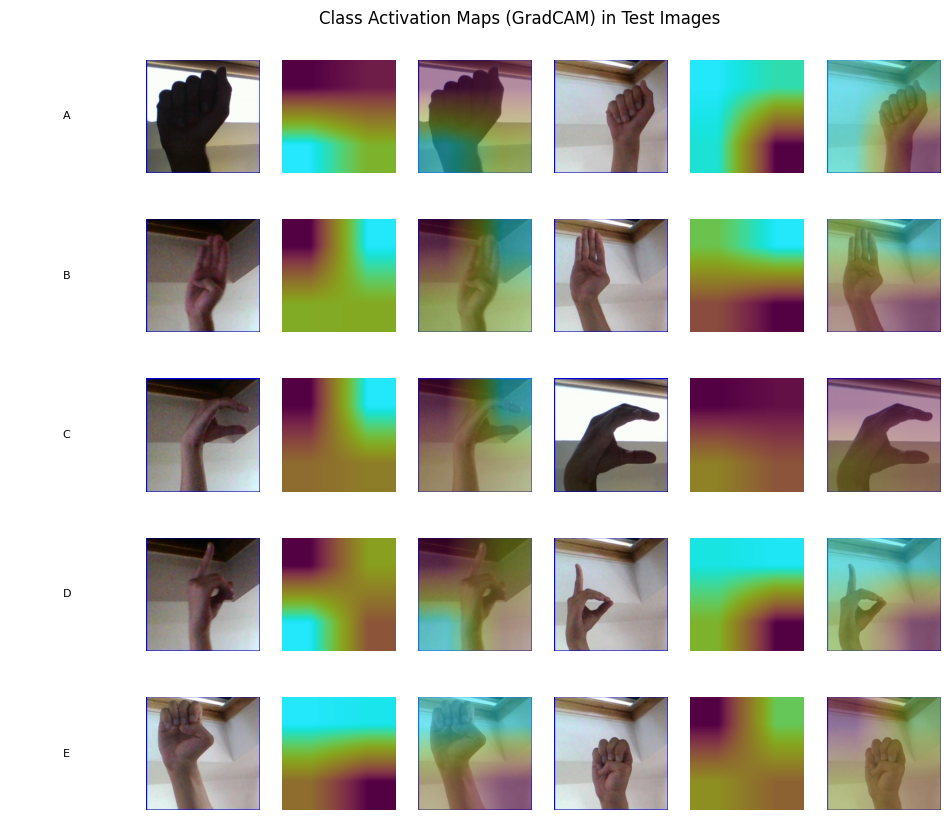

In [ ]:
gradcam_images(labels[:5])

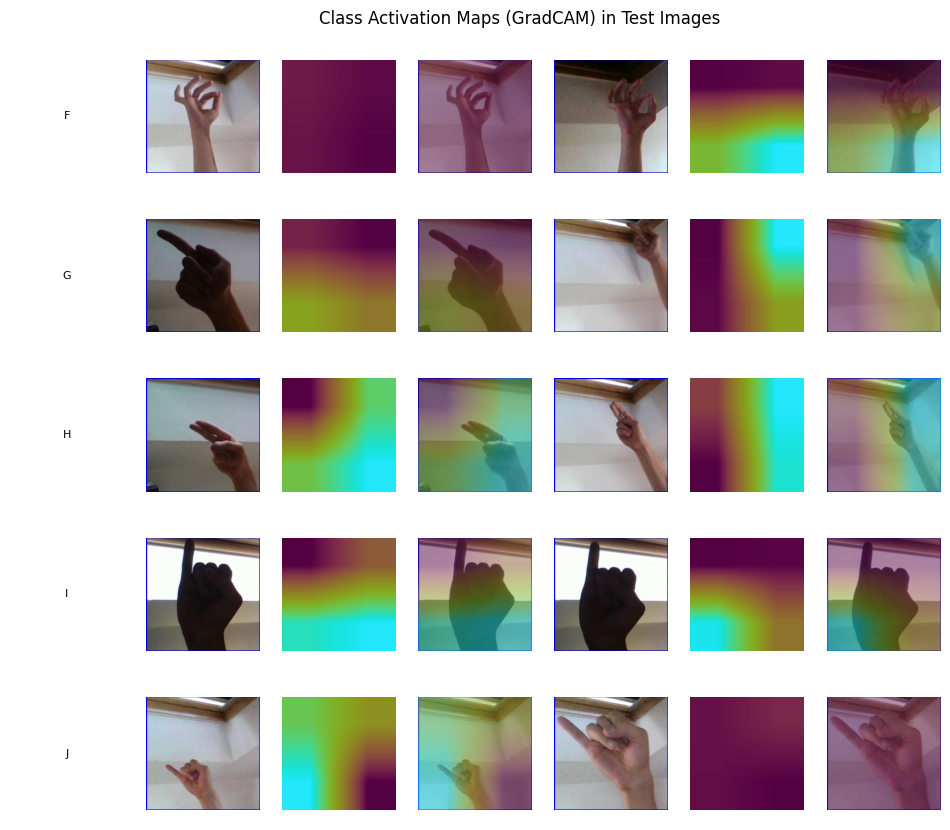

In [ ]:
gradcam_images(labels[5:10])

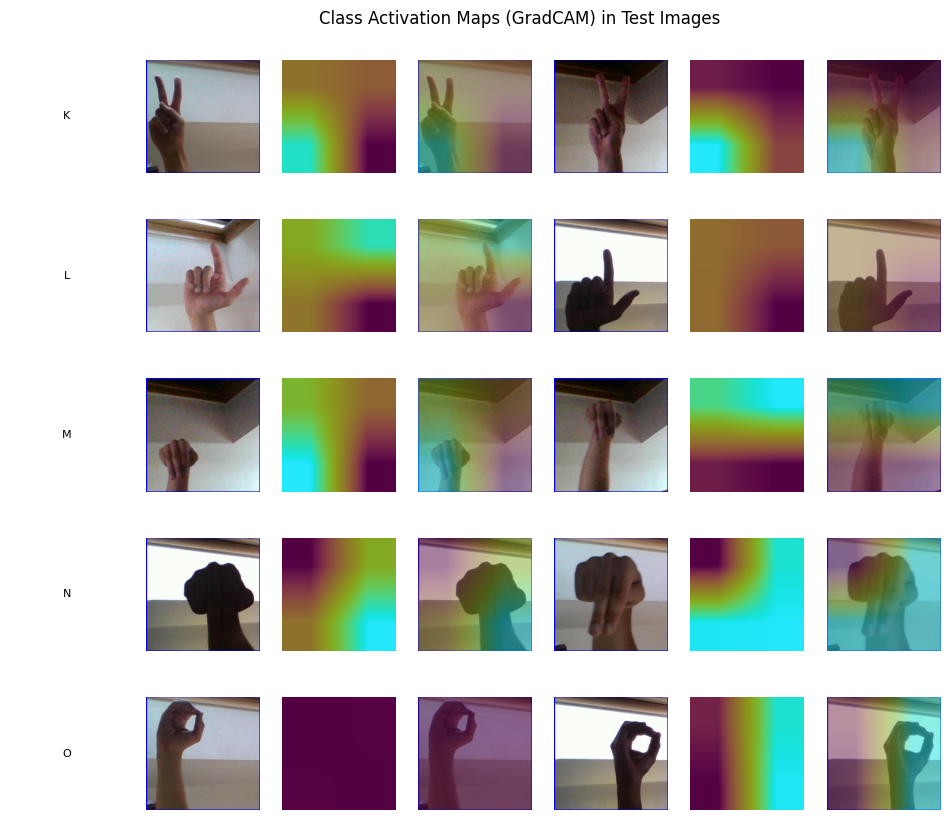

In [ ]:
gradcam_images(labels[10:15])

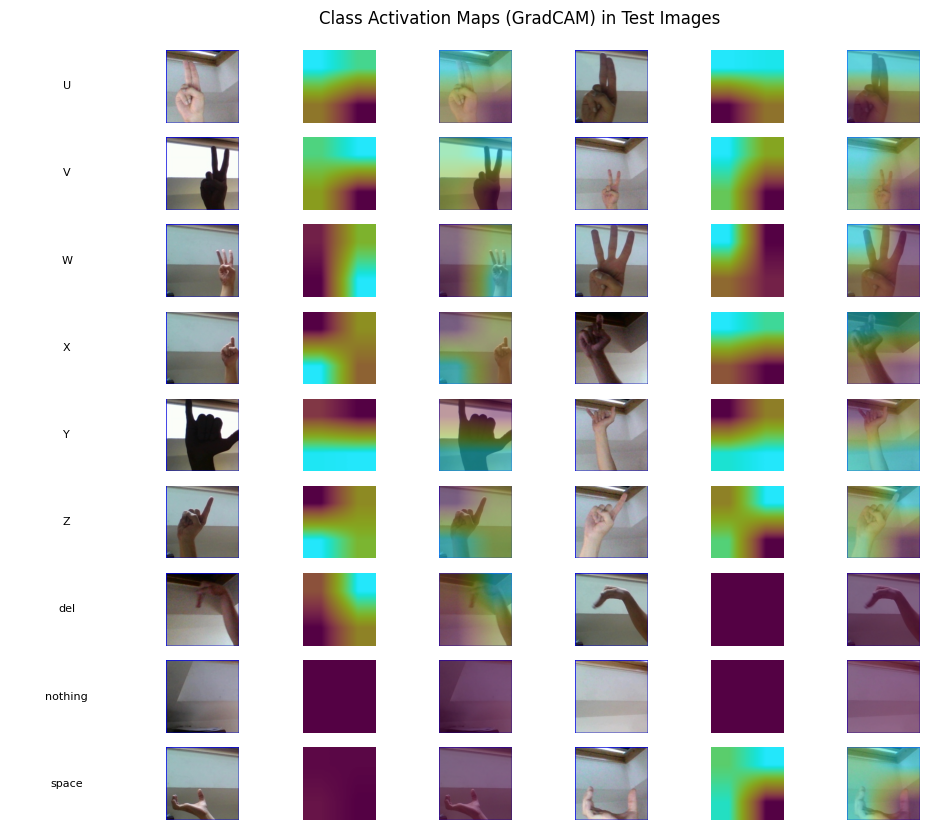

In [ ]:
gradcam_images(labels[20:])

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16


class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 10
    num_classes = 29
    img_channels = 3


def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


finalmodel = VGG16(weights='asl_vgg16_best_weights.h5', include_top=False, input_shape=(CFG.img_height, CFG.img_width, CFG.img_channels))